# 01/24/19: Fitting the rod in vacuum 

In [3]:
import sys

import numpy as np
import scipy.optimize as opt
import scipy.io as sio
import scipy.constants as con

# import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
nm = 1e-7

modules_folder = ('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/'
    +
    'Mispolarization/python/gitted/solving_problems/modules')
sys.path.append(modules_folder)
import coupled_dipoles as cp

nm = 1e-7
a_x = 44*nm
a_y = 20*nm
a_z = 20*nm
# cp.long_sigma_scat_ret_pro_ellip(2.0/hbar, 10, 9/hbar, 0.06/hbar, 1., a_x*nm, a_y*nm)

reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_vacuum.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


In [4]:
spectra_file_name = 'curly_rod_spectra_AuDrude_epsb1p0.mat'
## load matlab spectra with 
## sio.loadmat('fields_from_BEM')
path_to_spectra = '/Users/chair/Documents/MATLAB/012419/' + spectra_file_name

loaded_spectra = sio.loadmat(path_to_spectra)



In [5]:
loaded_spectra.keys()

dict_keys(['__header__', '__version__', '__globals__', 'long_mode', 'trans_mode'])

In [6]:
loaded_spectra['long_mode'].shape

(150, 3)

In [7]:
long_sigma = loaded_spectra['long_mode'][:,1]*(1e-14) ## cm^2/nm^2
trans_sigma = loaded_spectra['trans_mode'][:,1]*(1e-14)

long_lambdas = loaded_spectra['long_mode'][:,0]
trans_lambdas = loaded_spectra['trans_mode'][:,0]

long_hbarws = 1240/long_lambdas
trans_hbarws = 1240/trans_lambdas

In [8]:
def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.long_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10
def ret_fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10

#+++++++++++++++++++++++++++++++++++++++++++++

def ret_leastsq_func(params, *args):
    x1=args[0]
    x2=args[1]
    y1=args[2]*1e10
    y2=args[3]*1e10
    y = np.hstack((y1,y2))
#     data=args[2:]

    eps_inf=params[0]
    w_p=params[1]
    gamma=params[2]
    a1 =params[3]
    a2 = params[4]
    
    cc = 2
#     print(x.shape)
#     incs = np.shape(x[0])[0]
    yfit=np.empty(np.hstack((y1,y2)).shape)
    for i in range(cc):
        if i==0:
            yfit[:x1.shape[0]]=ret_fit_scat_1(x1,*params)
        elif i==1:
            yfit[x1.shape[0]:]=ret_fit_scat_2(x2,*params)
    return y-yfit


#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([9.8, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[long_hbarws, trans_hbarws, long_sigma, trans_sigma]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

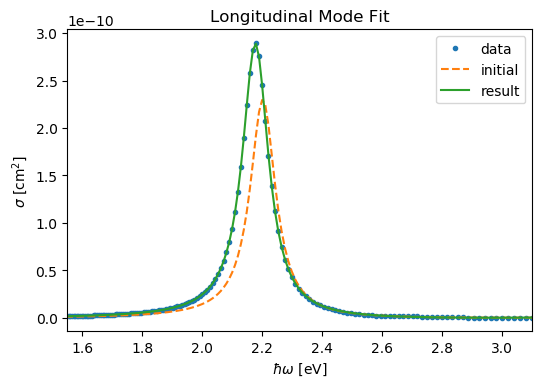

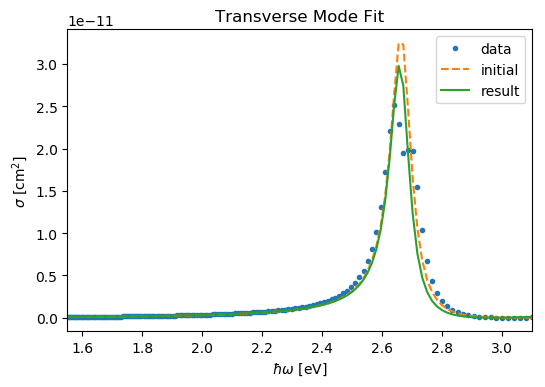

In [10]:
plt.figure(dpi=100)
plt.plot(long_hbarws, long_sigma, label='data', ls=' ', marker='.')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *ini_guess_both)*1e-10,label='initial', ls='--')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *result['x'])*1e-10,label='result', ls='-')
plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Longitudinal Mode Fit')
plt.legend()

plt.figure(dpi=100)
plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both)*1e-10, label='initial', ls='--')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Transverse Mode Fit')
plt.legend()

In [11]:
result['x']

array([11.59368545,  9.65413422,  0.06807553, 48.04291551, 19.93376247])

Old result was 

``array([15.100176  , 10.15232758,  0.10316881, 67.24906658, 19.20816015])``

where the fit values correspond to 

``[eps_inf, hbarw_p, hbargamma, a_1, a_2]``

Doing better on the radii, let me go check the BEM Drude params

From MNPBEM source file ``'MNPBEM/Material/@epsdrude/init.m'``

```Matlab
function obj = init( obj )
%  Initialize Drude dielectric function.

%  atomic units
hartree = 27.2116;              %  2 * Rydberg in eV
tunit = 0.66 / hartree;         %  time unit in fs

switch obj.name
  case { 'gold_eps_inf_to_1' }  
    rs = 3;                     %  electron gas parameter
    obj.eps0 = 1;              %  background dielectric constant
    gammad = tunit / 10;        %  Drude relaxation rate
  case { 'Au', 'gold' }
    rs = 3;                     %  electron gas parameter
    obj.eps0 = 10;              %  background dielectric constant
    gammad = tunit / 10;        %  Drude relaxation rate
  case { 'Ag', 'silver' }
    rs = 3;
    obj.eps0 = 3.3;
    gammad = tunit / 30;
  case { 'Al', 'aluminum' }
    rs = 2.07;
    obj.eps0 = 1;
    gammad = 1.06 / hartree;
  otherwise
    error( 'Material name unknown' );
end

%  density in atomic units
density = 3 / ( 4 * pi * rs ^ 3 );
%  plasmon energy
wp = sqrt( 4 * pi * density );

%  save values
obj.gammad = gammad * hartree;
obj.wp     = wp     * hartree;

    
```

Calculating values

In [12]:
hartree = 27.2116
tunit = 0.66 / hartree

rs = 3
eps0 = 10
gammad = tunit / 10 * hartree

In [13]:
density = 3 / ( 4 * np.pi * rs**3 )
wp = np.sqrt( 4 * np.pi * density )* hartree

In [14]:
print("gammad = ", gammad)
print("eps0 = ", eps0)
print("wp = ", wp)

gammad =  0.066
eps0 =  10
wp =  9.070533333333335


So I did suprisingly well. 

In [15]:
param_str_list = ['eps_inf', 'hbarw_p', 'hbargamma', 'a_1', 'a_2']

new_fit_results=dict(zip(param_str_list, result['x']))
print(f"new_fit_results = {new_fit_results}",'\n')
old_fit_result_list = np.array([15.100176  , 10.15232758,  0.10316881, 67.24906658, 19.20816015])
old_fit_results = dict(zip(param_str_list, old_fit_result_list))
print(f"old_fit_results = {old_fit_results}")


new_fit_results = {'eps_inf': 11.593685450998338, 'hbarw_p': 9.65413421804693, 'hbargamma': 0.06807552712549593, 'a_1': 48.042915506229754, 'a_2': 19.93376246540251} 

old_fit_results = {'eps_inf': 15.100176, 'hbarw_p': 10.15232758, 'hbargamma': 0.10316881, 'a_1': 67.24906658, 'a_2': 19.20816015}


## Wondering if I can do better by avoiding the second trans peak
---
Dip appears at $\hbar\omega = 2.670$

In [16]:
index_to_267 = np.where(trans_hbarws<2.67)
index_to_267

(array([ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149]),)

In [17]:
trans_hbarws[index_to_267]

array([2.6699422 , 2.6545977 , 2.63942857, 2.62443182, 2.60960452,
       2.59494382, 2.58044693, 2.56611111, 2.5519337 , 2.53791209,
       2.52404372, 2.51032609, 2.49675676, 2.48333333, 2.47005348,
       2.45691489, 2.44391534, 2.43105263, 2.41832461, 2.40572917,
       2.39326425, 2.38092784, 2.36871795, 2.35663265, 2.34467005,
       2.33282828, 2.32110553, 2.3095    , 2.29800995, 2.28663366,
       2.27536946, 2.26421569, 2.25317073, 2.24223301, 2.23140097,
       2.22067308, 2.21004785, 2.19952381, 2.18909953, 2.17877358,
       2.1685446 , 2.15841121, 2.14837209, 2.13842593, 2.12857143,
       2.11880734, 2.10913242, 2.09954545, 2.09004525, 2.08063063,
       2.07130045, 2.06205357, 2.05288889, 2.04380531, 2.03480176,
       2.02587719, 2.01703057, 2.00826087, 1.9995671 , 1.99094828,
       1.98240343, 1.97393162, 1.96553191, 1.95720339, 1.94894515,
       1.9407563 , 1.93263598, 1.92458333, 1.91659751, 1.90867769,
       1.90082305, 1.89303279, 1.88530612, 1.87764228, 1.87004

In [18]:

ini_guess_both=np.array([11, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[long_hbarws, trans_hbarws[index_to_267], long_sigma, trans_sigma[index_to_267]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

no_trans_quad_result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

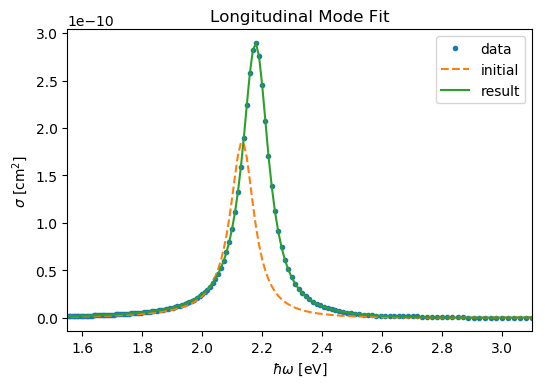

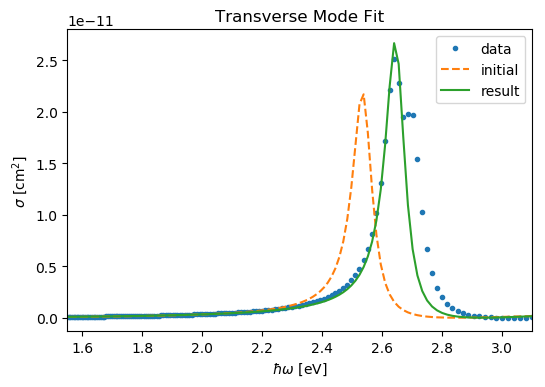

In [19]:
plt.figure(dpi=100)
plt.plot(long_hbarws, long_sigma, label='data', ls=' ', marker='.')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *ini_guess_both)*1e-10,label='initial', ls='--')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *no_trans_quad_result['x'])*1e-10,label='result', ls='-')
plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Longitudinal Mode Fit')
plt.legend()

plt.figure(dpi=100)
plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both)*1e-10, label='initial', ls='--')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *no_trans_quad_result['x'])*1e-10, label='result', ls='-')
plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Transverse Mode Fit')
plt.legend()

That looks really good, lets check it out. 

In [20]:
fit_results_no_trans_quad=dict(zip(param_str_list, no_trans_quad_result['x']))
fit_results_no_trans_quad

{'eps_inf': 12.42358064082486,
 'hbarw_p': 9.896193581047589,
 'hbargamma': 0.06778709544892923,
 'a_1': 48.558393197333274,
 'a_2': 19.931635421512183}

Hmmmmmm that seems worse then before


In [21]:
new_fit_results

{'eps_inf': 11.593685450998338,
 'hbarw_p': 9.65413421804693,
 'hbargamma': 0.06807552712549593,
 'a_1': 48.042915506229754,
 'a_2': 19.93376246540251}

### I'm confused that the fit results got worse, maybe the higher energy peak in the dipole?

In [22]:
index_above_267 = np.where(trans_hbarws>=2.67)

ini_guess_both=np.array([11, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[long_hbarws, trans_hbarws[index_above_267], long_sigma, trans_sigma[index_above_267]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

no_trans_quad_result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

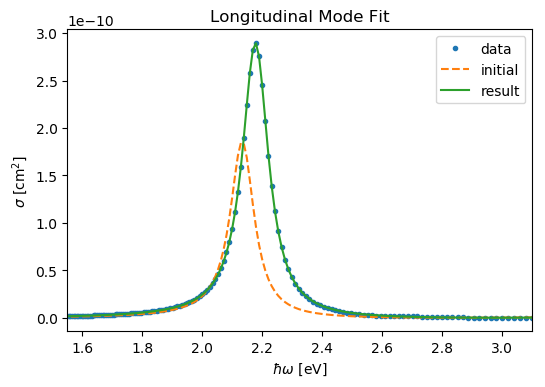

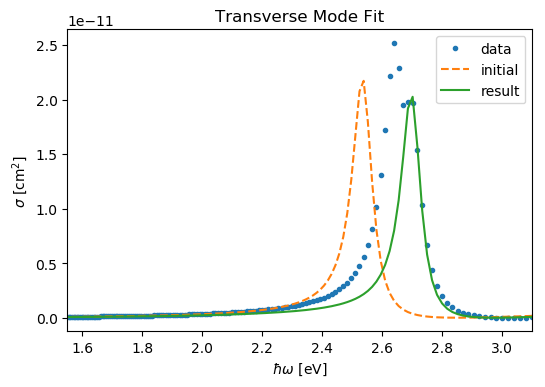

In [23]:
plt.figure(dpi=100)
plt.plot(long_hbarws, long_sigma, label='data', ls=' ', marker='.')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *ini_guess_both)*1e-10,label='initial', ls='--')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *no_trans_quad_result['x'])*1e-10,label='result', ls='-')
plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Longitudinal Mode Fit')
plt.legend()

plt.figure(dpi=100)
plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both)*1e-10, label='initial', ls='--')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *no_trans_quad_result['x'])*1e-10, label='result', ls='-')
plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Transverse Mode Fit')
plt.legend()

In [24]:
dict(zip(param_str_list, no_trans_quad_result['x']))


{'eps_inf': 12.908326291263885,
 'hbarw_p': 10.248647965010242,
 'hbargamma': 0.06809893154023487,
 'a_1': 49.23668672036996,
 'a_2': 18.510953331428315}

No, thats even worse, which is good. It must just be coincidental that fitting the double peak yields closer drude parameters. I will assum remaining error is dies to the rod not truly being a prolate ellipsoid. 

##### 02/07/19: What happens if I rescale the second peak to be equal order to first? Is that screwing up the fit?

Probably not, simply because the fit looks really good. I should probably just go with it for now. 

# 02/20/19: Going back to water
## have not changed anything in code yet, but my plan is to see how I do first, then change k 